# Week7

## Part 2: Community detection

For example if you open the page for The Rolling Stones, you'll see that it contains info about their place of origin, the genres of music they've been associated with (in the case of the Stones it's rock, pop and blues), their year's active, the record labels they've signed with over time, etc. All really interesting information if we want to understand the network of artists.

So let's start with an exercise designed to give you a sense of how good the LLMs are at the whole text-parsing thing.

**Exercise: Go nuts with an LLM and get all the genres for the nodes in your network**

- Yes, I'm serious. For this one I'd like you to fire up your most powerful thinking model you have access to and get it to write a script to extract genre for all nodes in your network. Some notes to help you
If the node doesn't have an infobox (or if a node's infobox doesn't have a genre it it), just don't assign that node a genre and ignore it in the downstream analysis
Remember to lowercase all genres, also consider simplifying things by mapping rock'n'roll, rock & roll, etc to a single genre.
Remember to test your algorithm well before emplying it, since you're not writing the code yourself, you need to work harder to prove to yourself that it's actually doing what you think it's doing. You should inspect the code to understand what it's actually doing and also test it on the strangest edge-cases you can find. (Can it handle, "The Animals", for example).
The output should be a dictionary mapping artist names to lists of genres (since most artists have multiple genres listed).
- Report the following stats
  - The number of nodes for which you could find genres
  - The average number of genres per node
  - The total number of distinct genres
  - A histogram showing artist counts for the top 15 genres

Running with enhanced filtering logic...

--- Final Statistics ---
The number of nodes for which you could find genres: 203
The average number of genres per node: 3.06
The total number of distinct genres: 193


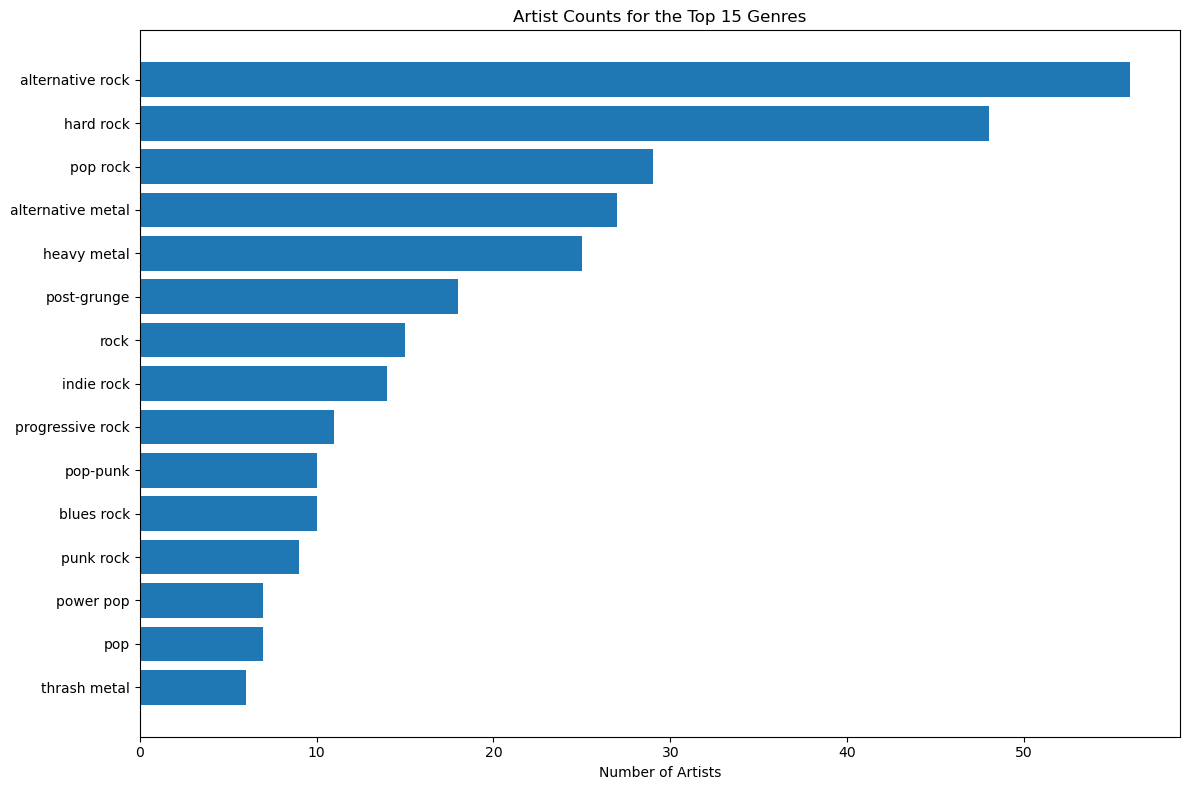

In [26]:
import os
import re
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def extract_genres_from_wikitext(wikitext, artist_name, debug=False):
    """
    Parses wikitext to find and clean genres, now with stricter filtering
    to remove non-genre junk like URLs and template fragments.
    """
    if not isinstance(wikitext, str):
        return None

    # Step 1: Find the entire infobox.
    infobox_match = re.search(r'\{\{(Infobox musical artist|Infobox band|Infobox person)(.*?)\}\}', wikitext, re.DOTALL | re.IGNORECASE)
    if not infobox_match:
        return None
    infobox_content = infobox_match.group(2)

    # Step 2: Find the genre field using our robust method.
    genre_field_match = re.search(r'\n\s*\|\s*genre\s*=', infobox_content, re.IGNORECASE)
    if not genre_field_match:
        return None

    text_after_genre = infobox_content[genre_field_match.end():]
    next_field_match = re.search(r'\n\s*\|', text_after_genre)
    
    if next_field_match:
        raw_genres = text_after_genre[:next_field_match.start()]
    else:
        raw_genres = text_after_genre

    # Step 3: Initial cleanup (this part is the same).
    raw_genres = re.sub(r'<!--.*?-->', '', raw_genres, flags=re.DOTALL)
    raw_genres = re.sub(r'<ref.*?>.*?</ref>', '', raw_genres, flags=re.DOTALL)
    raw_genres = re.sub(r'<.*?>', '', raw_genres)
    raw_genres = re.sub(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', r'\1', raw_genres)
    # More aggressive template removal
    raw_genres = re.sub(r'\{\{.*?\}\}', '', raw_genres, flags=re.DOTALL)
    raw_genres = raw_genres.replace('}}', '')

    # Step 4: Split into a list of potential genres.
    genres = re.split(r'[,/\n*]', raw_genres)

    # --- NEW & IMPROVED: FINAL FILTERING ---
    cleaned_genres = []
    # List of junk words to ignore. Can be expanded if you see more.
    junk_words = {'artist', 'web', 'website', 'title', 'url', 'cite'} 

    for genre in genres:
        genre = genre.strip().lower()
        
        # --- Quality Control Checks ---
        if not genre:
            continue  # Skip empty strings that result from splitting.
        if genre in junk_words:
            continue  # Skip common junk words.
        if '.' in genre and ('com' in genre or 'org' in genre or 'gov' in genre):
            continue  # Skip things that look like URLs.
        if any(char in genre for char in ['|', '=', '{', '}']):
            continue  # Skip leftover template fragments.
        if len(genre) > 25:
            continue # Skip overly long strings which are likely errors.
        
        # --- End of Quality Control ---

        # Standardize "rock and roll"
        if 'rock' in genre and ('&' in genre or 'and' in genre) and 'roll' in genre:
            genre = 'rock and roll'
        
        cleaned_genres.append(genre)

    return cleaned_genres if cleaned_genres else None


# --- Main Script Execution (No changes needed here) ---

bands_folder_path = r"/Users/noa/Desktop/02805 - Social Graphs/SocialGraphs/Assignment1/bands"
artist_genres_map = {}

if not os.path.isdir(bands_folder_path):
    print(f"Error: The directory '{bands_folder_path}' does not exist.")
else:
    print("Running with enhanced filtering logic...")
    for filename in os.listdir(bands_folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(bands_folder_path, filename)
            artist_name = os.path.splitext(filename)[0].replace('_', ' ')

            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)

                wikitext = None
                pages = data.get('query', {}).get('pages', {})
                if pages:
                    page_id = next(iter(pages))
                    page = pages[page_id]
                    if 'revisions' in page and page['revisions'] and 'slots' in page['revisions'][0]:
                        slots = page['revisions'][0]['slots']
                        if 'main' in slots and '*' in slots['main']:
                             wikitext = slots['main']['*']
                
                if wikitext:
                    genres = extract_genres_from_wikitext(wikitext, artist_name)
                    if genres:
                        artist_genres_map[artist_name] = genres

            except Exception as e:
                print(f"An unexpected error occurred with file {filename}: {e}")

# --- Reporting Stats ---

if not artist_genres_map:
    print("\nExecution finished. Could not find any genres.")
else:
    num_nodes_with_genres = len(artist_genres_map)
    total_genres_found = sum(len(g) for g in artist_genres_map.values())
    average_genres_per_node = total_genres_found / num_nodes_with_genres
    all_genres = [genre for genres in artist_genres_map.values() for genre in genres]
    total_distinct_genres = len(set(all_genres))

    print("\n--- Final Statistics ---")
    print(f"The number of nodes for which you could find genres: {num_nodes_with_genres}")
    print(f"The average number of genres per node: {average_genres_per_node:.2f}")
    print(f"The total number of distinct genres: {total_distinct_genres}")

    genre_counts = Counter(all_genres)
    top_15_genres = genre_counts.most_common(15)

    if top_15_genres:
        genres, counts = zip(*top_15_genres)
        plt.figure(figsize=(12, 8))
        y_pos = np.arange(len(genres))
        plt.barh(y_pos, counts, align='center')
        plt.yticks(y_pos, labels=genres)
        plt.gca().invert_yaxis()
        plt.xlabel('Number of Artists')
        plt.title('Artist Counts for the Top 15 Genres')
        plt.tight_layout()
        plt.show()

Create a graph using the bands as nodes and genres as attributes

In [49]:
import networkx as nx

# Create an empty graph
G_artists = nx.Graph()

# clean artists names to match
def sanitize_filename(name):
    # Replace any char that is a "(,),/,\,?,%,*,:,|,",<,>,., " " with underscore
    return re.sub(r'[()\/\\\?%*:|<>.\s]', '_', name)

# clean artist names in the artist_genres_map.items()
artist_genres_map = {sanitize_filename(artist): genres for artist, genres in artist_genres_map.items()}


# Add nodes to the graph from the artist_genres_map
# The keys of the dictionary are the artist names (nodes)
# The values are the lists of genres (attributes)
for artist, genres in artist_genres_map.items():
    G_artists.add_node(artist, genres=genres)

print(f"Created a graph with {G_artists.number_of_nodes()} nodes.")

# print first 5 nodes
print("First 5 nodes in the graph with their genres:")
for i, (node, data) in enumerate(G_artists.nodes(data=True)):
    if i >= 5:
        break
    print(f"{node}: {data['genres']}")

Created a graph with 203 nodes.
First 5 nodes in the graph with their genres:
Slayer: ['thrash metal']
Great_White: ['hard rock']
Anthrax__American_band_: ['thrash metal', 'heavy metal', 'groove metal']
Flogging_Molly: ['celtic punk', 'folk punk']
Simple_Plan: ['pop-punk', 'alternative rock', 'pop rock', 'power pop', 'emo']


Now we will add the links, by using the graph used for assignment 1

In [52]:
# import link list from rock_music_graph.graphml
G_links = nx.read_graphml(r"/Users/noa/Desktop/02805 - Social Graphs/SocialGraphs/Assignment1/rock_music_graph.graphml")
print(f"Imported link graph with {G_links.number_of_nodes()} nodes and {G_links.number_of_edges()} edges.")

# remove Allmusic node
if 'Allmusic' in G_links:
    G_links.remove_node('Allmusic')
    print("Removed 'Allmusic' node from the link graph.")

# sanitize node names in G_links to match
mapping = {node: sanitize_filename(node) for node in G_links.nodes()}
G_links = nx.relabel_nodes(G_links, mapping)

# --- Now we can proceed to add edges to G_artists based on G_links ---
G = G_artists.copy()

for u, v in G_links.edges():
    if G.has_node(u) and G.has_node(v):
        G.add_edge(u, v)

print(f"The final graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Imported link graph with 473 nodes and 7452 edges.
The final graph has 203 nodes and 1210 edges.


In [58]:
import itertools

# print name of 30 first nodes in G_links

# Get the first 30 nodes from each graph, sorted alphabetically
g_links_nodes = sorted(list(G_links.nodes()))[:10]
g_nodes = sorted(list(G.nodes()))[:10]

# Print the headers for the side-by-side comparison
print(f"{'G_links Nodes':<40} | {'G (Final Graph) Nodes':<40}")
print("-" * 83)

# Iterate and print nodes side-by-side
# Use zip_longest to handle cases where one list might be shorter than the other
for node_link, node_g in itertools.zip_longest(g_links_nodes, g_nodes, fillvalue=""):
    print(f"{node_link:<40} | {node_g:<40}")

G_links Nodes                            | G (Final Graph) Nodes                   
-----------------------------------------------------------------------------------
10_Years__band_                          | 10cc                                    
10cc                                     | 311__band_                              
311__band_                               | 38_Special__band_                       
38_Special__band_                        | 3_Doors_Down                            
3_Doors_Down                             | AC_DC                                   
ABBA                                     | A_Perfect_Circle                        
AC_DC                                    | Accept__band_                           
AFI__band_                               | Aerosmith                               
A_Perfect_Circle                         | Alice_in_Chains                         
Accept__band_                            | Alter_Bridge                     

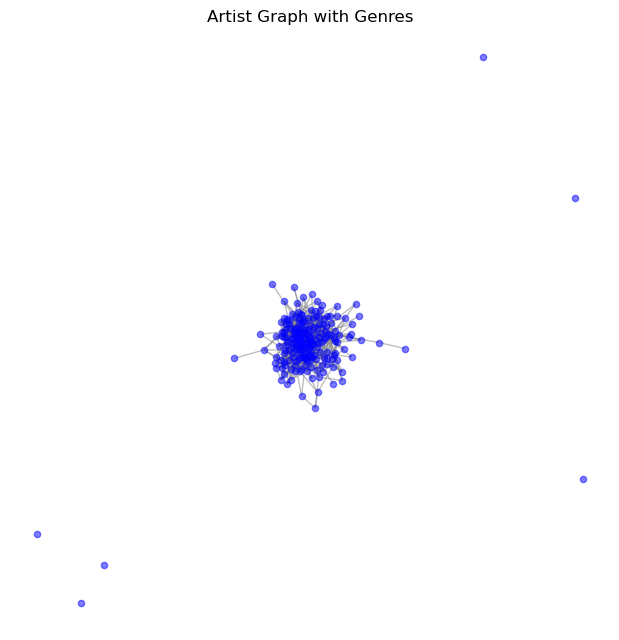

In [59]:
# plot graph
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes
nx.draw(G, pos, node_size=20, node_color='blue', edge_color='gray', alpha=0.5)
plt.title("Artist Graph with Genres")
plt.show()

Now that we have the genres, let's use them - and see how community-like the community is, if we consider the genres to be community labels.

**Exercise: Use the concept of modularity to explore how community-like the genres are.**

- Explain the concept of modularity in your own words.
- Work from the undirected version of the network, keeping only the nodes for which you have genre information.
- Now create your own partition of the network into genres.
- Each node is simply characterized by the first genre in its list of genres.
- Each community is the group of nodes that share the same genre.
- That's all you need, now calculate the modularity of this division of the network into genres.
- Note: Modularity is described in the Network Science book, section 9.4.. Thus, use equation 9.12 in the book to calculate the modularity 
 of the partition described above. Are the genres good communities?
- Spoiling your findings a little bit, an issue is the following: Almost all artists have the genre rock as their first genre in the list, so by definition the network won't have very high modularity.
- What happens to the modularity if you grab the first genre that's not rock as the genre-assignment for all nodes that have more than one genre?
- What happens to the modularity if you use a random genre from the list genre as the node-lable for those nodes with more than one genre listed?
- Discuss your findings.

**Explain the concept of modularity in your own words.**

**Work from the undirected version of the network, keeping only the nodes for which you have genre information.**
- Now create your own partition of the network into genres.
- Each node is simply characterized by the first genre in its list of genres.
- Each community is the group of nodes that share the same genre.
- That's all you need, now calculate the modularity of this division of the network into genres.
- Note: Modularity is described in the Network Science book, section 9.4.. Thus, use equation 9.12 in the book to calculate the modularity of the partition described above. Are the genres good communities?

In [56]:
import networkx as nx
from collections import defaultdict

# --- 2. Create a partition where each community is a genre ---
# Each node is assigned to the community of its *first* listed genre.
communities_by_genre = defaultdict(list)
for node, data in G.nodes(data=True):
    genres = data.get('genres')
    if genres:
        first_genre = genres[0]
        communities_by_genre[first_genre].append(node)

# The modularity function requires a list of sets (the communities).
partition = [set(nodes) for nodes in communities_by_genre.values()]
print(f"\nCreated a partition with {len(partition)} communities based on the first genre.")

# --- 3. Calculate and report the modularity ---
if G.number_of_edges() > 0:
    modularity_score = nx.community.modularity(G, partition)
    print(f"\nThe modularity of this partition is: {modularity_score:.4f}")
else:
    print("\nCannot calculate modularity: The graph has no edges.")


Created a partition with 73 communities based on the first genre.

The modularity of this partition is: 0.0646


**Are the genres good communities?**
A score near or below zero indicates the partitioning is no better than random.

The modularity of this partition is: 0.0646

**Exercise**
- Spoiling your findings a little bit, an issue is the following: Almost all artists have the genre rock as their first genre in the list, so by definition the network won't have very high modularity.
- What happens to the modularity if you grab the first genre that's not rock as the genre-assignment for all nodes that have more than one genre?
- What happens to the modularity if you use a random genre from the list genre as the node-lable for those nodes with more than one genre listed?
- Discuss your findings.

In [60]:
# number of nodes that has Rock as their first genre
rock_community_size = len(communities_by_genre.get('rock', []))
print(f"\nNumber of nodes with 'rock' as their first genre: {rock_community_size}")


Number of nodes with 'rock' as their first genre: 14


We didnt have that all our bands has rock as their first genre, so this assignment doesn't make sense to do.

**Exercise: Community detection to find structral communities in the network**

- Again, work only with the subnetwork of nodes that have at least one genre.
- Use the Louvain-algorithm to find communities for the network. Report the value of modularity found by the algorithm.
- What is the modularity of this partitioning of the network? Is it more community-like than the genres? What does this comparison reveal about the communities?
- Visualize the network, using the Force Atlas algorithm.
- This time assign each node a different color based on its structural community.
- Note: If there's a lot of small communities, it's OK to only color the 5-10 largest communities (you can make the remaing nodes light gray or some netural color)
- Describe the structure you observe.
- Keep using the community labels from above, but now visualize only the backbone-edges from your favorite network backbone from last week. - - Do the community correspond to the backbone structure you detected?

In [61]:
#using networkx louvain_communities to find communities
louvain_communities = list(nx.community.louvain_communities(G, seed=42))
louvain_modularity = nx.community.modularity(G, louvain_communities)
print(f"\nLouvain method found {len(louvain_communities)} communities with a modularity of {louvain_modularity:.4f}.")



Louvain method found 10 communities with a modularity of 0.3664.


**What is the modularity of this partitioning of the network? Is it more community-like than the genres? What does this comparison reveal about the communities?**
